**Author:** Andy Tzanidakis and the LINCC team \
**Last updated**: Aug 26, 2024

## Overview

In this notebook we will learn how to use use `nested-pandas` to compute time-series features from LSDB catalogs.

In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
import astropy.units as u
import dask
from dask.distributed import Client

# Local library-specific imports
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from hipscat.inspection import plot_pixels
from hipscat.io.file_io import read_parquet_metadata

# Astropy
from astropy.timeseries import LombScargle

# Jupyter-specific settings and magic commands
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Configuration settings
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
mpl.rcParams['axes.linewidth'] = 2

print(f'Version of lsdb is {lsdb.__version__}')

Version of lsdb is 0.2.10.dev40+g57dca96


In [2]:
catalogs_dir = "https://data.lsdb.io/unstable/"

# Gaia
gaia_path = f"{catalogs_dir}/gaia_dr3/gaia"

# ZTF
ztf_object_path = f"{catalogs_dir}/ztf/ztf_dr14/"
ztf_source_path = f"{catalogs_dir}/ztf/ztf_zource/"

## Initialize Dask Client

Before we start building our workflow, let's initialize our Dask Client. The machine we're using has 8 cores and 25GiB of RAM so we'll decide to make good use of resources and go with 4 workers, each with 6 GiB of memory and 1 thread.

In [3]:
from dask.distributed import Client
client = Client(n_workers=4, memory_limit="6GiB", threads_per_worker=1)

/astro/users/smcampos/.conda/envs/busy-week/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46183 instead
  warnings.warn(


## Get Gaia and ZTF

Let's read Gaia and ZTF (both lazily) as demonstrated in the first notebook.

In [4]:
%%time

# Load Gaia object table
gaia = lsdb.read_hipscat(gaia_path, columns=['ra', 'dec', 'parallax'])

# Define a cone region of interest for ZTF
cone_search = ConeSearch(ra=132.8460000, dec=+11.8140000, radius_arcsec=5_000)

# Load ZTF object table
ztf = lsdb.read_hipscat(ztf_object_path, columns=['ra', 'dec', 'ps1_objid'], search_filter=cone_search)

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat(ztf_source_path, columns=['ra', 'dec', 'mjd', 'mag', 'magerr', 'band', 'ps1_objid', 'catflags'], search_filter=cone_search)

/astro/users/smcampos/.conda/envs/busy-week/lib/python3.11/site-packages/hipscat/io/file_io/file_io.py:320: UserWarning: point_map.fits file written in RING ordering, due to https://github.com/astronomy-commons/hipscat/issues/271. Converting to NESTED.
  warnings.warn(
/astro/users/smcampos/.conda/envs/busy-week/lib/python3.11/site-packages/hipscat/io/file_io/file_io.py:320: UserWarning: point_map.fits file written in RING ordering, due to https://github.com/astronomy-commons/hipscat/issues/271. Converting to NESTED.
  warnings.warn(
/astro/users/smcampos/.conda/envs/busy-week/lib/python3.11/site-packages/hipscat/io/file_io/file_io.py:320: UserWarning: point_map.fits file written in RING ordering, due to https://github.com/astronomy-commons/hipscat/issues/271. Converting to NESTED.
  warnings.warn(


CPU times: user 1.33 s, sys: 429 ms, total: 1.75 s
Wall time: 1.73 s


## Create a sample object catalog

To create our sample let's crossmatch our ZTF region with Gaia with a 3-arcsecond radius.

In [5]:
%%time
_sample = ztf.crossmatch(gaia, radius_arcsec=3)

/astro/users/smcampos/.conda/envs/busy-week/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


CPU times: user 988 ms, sys: 29 ms, total: 1.02 s
Wall time: 998 ms


We can have a look at the object matches because this sample is relatively small and it fits in memory! 

In [6]:
_sample_computed = _sample.compute()
_sample_computed

,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec
_hipscat_index,,,,,,,
1195635224533270528,133.2337,10.485653,120581332336983267,133.233718,10.485637,0.445226,0.085933
1195635242824630272,133.224741,10.485489,120581332247203053,133.224727,10.485452,0.621834,0.141202
1195635245353795584,133.225766,10.486782,120581332257664629,133.22577,10.486761,0.777203,0.077445
1195681424221405184,133.35658,10.524734,120631333565320137,133.356574,10.524717,0.959385,0.065692
1195681461315829760,133.379456,10.52903,120631333794875301,133.379471,10.529019,<NA>,0.067189
...,...,...,...,...,...,...,...
1216416656180379648,132.783272,13.19324,123831327832352378,132.783269,13.193228,<NA>,0.044713
1216420518253559808,132.632037,13.177743,123811326320263743,132.632043,13.177703,<NA>,0.144951
1216420530047942656,132.630009,13.182842,123811326300059917,132.630009,13.182812,0.450537,0.110055


In [7]:
print (f"Number of objects in crossmatch: {len(_sample_computed)}")

Number of objects in crossmatch: 36717


We selected a very small region of the sky - 5000 arcsec - and, as a result, our objects are contained in just a handful of pixels. In the following mollview of the pixel map, the gray color means that our sample catalog does not have coverage for that region in space.

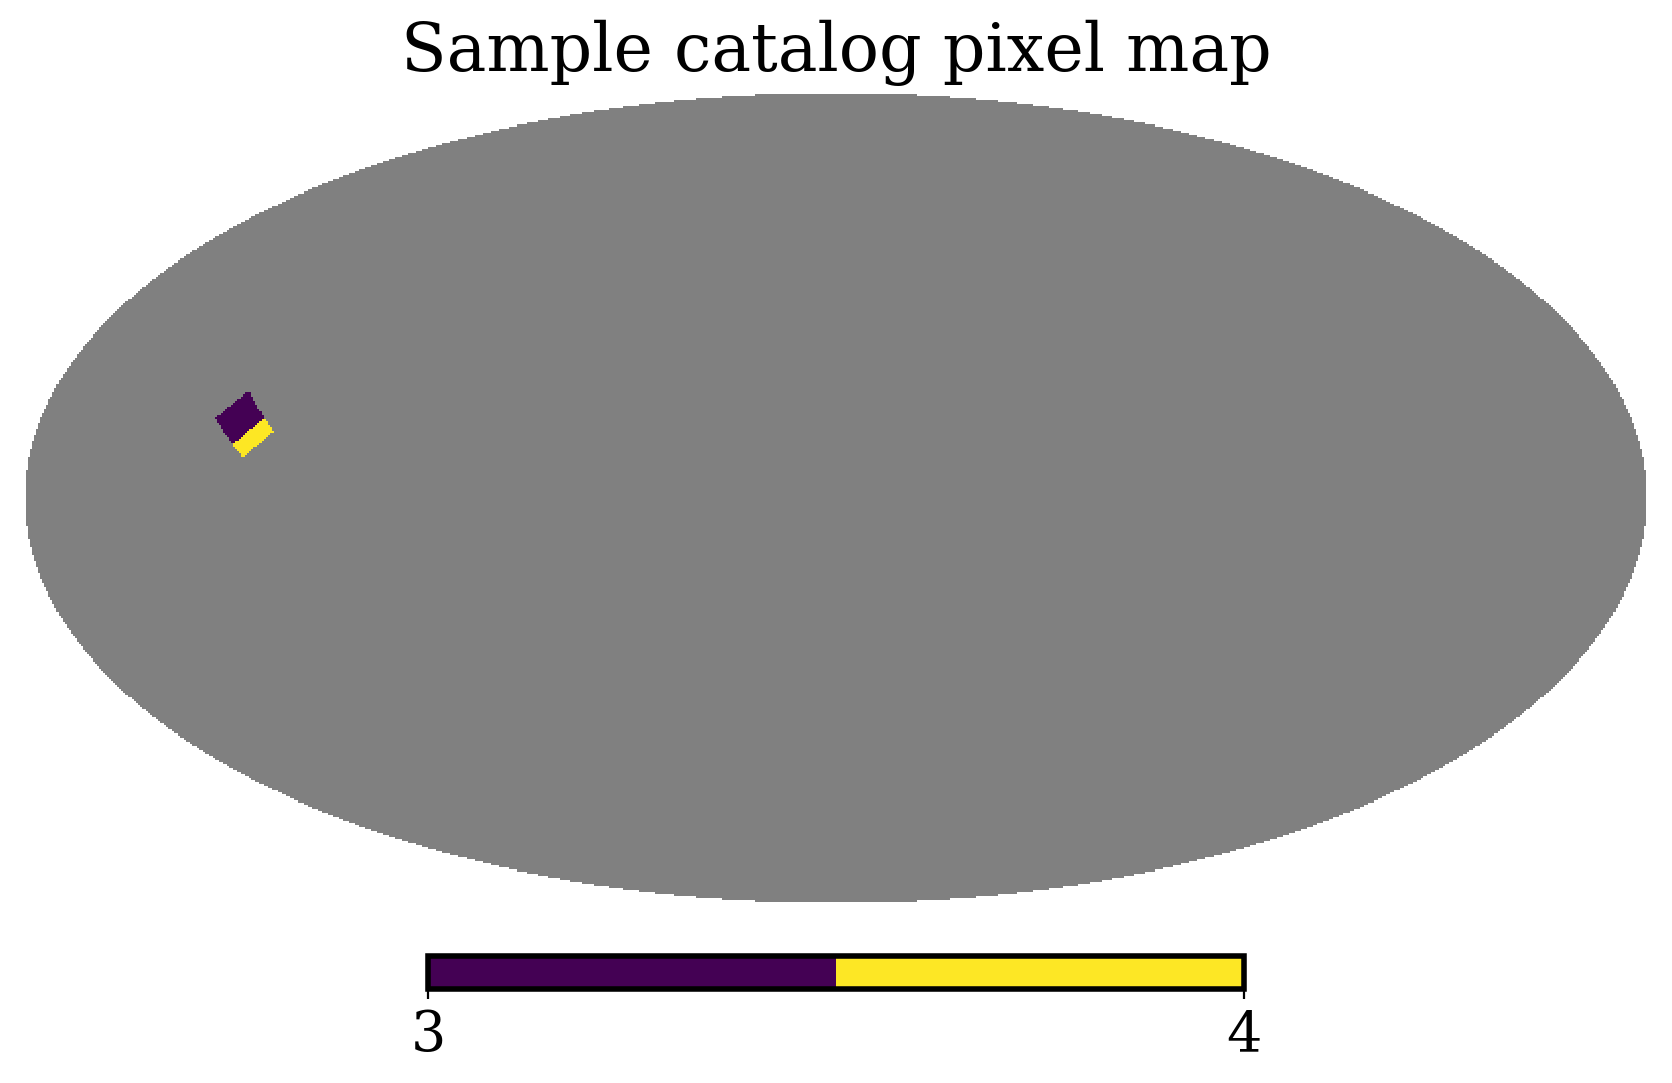

In [8]:
_sample.plot_pixels("Sample catalog pixel map")

## Fetch ZTF light curves for the samples

We will now perform a join operation between our sample objects and their respective ZTF sources. We will use the PanSTARRS object ID, as this is the index that both catalogs share. This is where `nested-pandas` features come in handy. Under the hood, this `join_nested` call packs the time-domain data of each object as an additional column, which we decided to conveniently name `ztf_sources`.

In [9]:
_sources = _sample.join_nested(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid", nested_column_name="ztf_sources")
_sources = _sources._ddf # remove once have added LSDB wrappers for nested_dask
_sources

/astro/users/smcampos/.conda/envs/busy-week/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:296: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec,ztf_sources
npartitions=6,,,,,,,,
1194579801160024064,double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],"nested<ra: [double], dec: [double], mjd: [double], mag: [float], magerr: [float], band: [string], catflags: [int16]>"
1196831600973709312,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
1215971899390033920,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...


Note that we also get a warning stating that we are not using a margin catalog, as previously discussed in the first notebook.

## Filter on r-band

Our workflow will only operate on r-band data. We can apply the necessary cuts to our data to make sure that only lightcurves that have at least 10 observations in r-band will be considered!

In [10]:
# Query for light curve data in r-band
r_band = _sources.query("ztf_sources.band == 'r'")
# Calculate the number of observations
nobs = r_band.reduce(np.size, "ztf_sources.mjd", meta={0: int}).rename(columns={0: "nobs"})
# Get only those light curves with at least 10 observations
r_band = r_band[nobs["nobs"] > 10]

In [11]:
%%time
r_band.compute()

CPU times: user 1.72 s, sys: 2.69 s, total: 4.41 s
Wall time: 21 s


,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec,ztf_sources
_hipscat_index,,,,,,,,
1195635224533270528,133.2337,10.485653,120581332336983267,133.233718,10.485637,0.445226,0.085933,ra dec mjd m...
1195635242824630272,133.224741,10.485489,120581332247203053,133.224727,10.485452,0.621834,0.141202,ra dec mjd ...
1195635245353795584,133.225766,10.486782,120581332257664629,133.22577,10.486761,0.777203,0.077445,ra dec mjd ...
1195681424221405184,133.35658,10.524734,120631333565320137,133.356574,10.524717,0.959385,0.065692,ra dec mjd ...
1195681461315829760,133.379456,10.52903,120631333794875301,133.379471,10.529019,<NA>,0.067189,ra dec mjd ...
...,...,...,...,...,...,...,...,...
1216416656180379648,132.783272,13.19324,123831327832352378,132.783269,13.193228,<NA>,0.044713,ra dec mjd ...
1216420518253559808,132.632037,13.177743,123811326320263743,132.632043,13.177703,<NA>,0.144951,ra dec mjd ...
1216420530047942656,132.630009,13.182842,123811326300059917,132.630009,13.182812,0.450537,0.110055,ra dec mjd ...


## Define Custom Time Series Function

We will now write custom analysis functions that can be passed along to each timeseries in our samples dataset.

#TODO: Add more information about what these functions are doing

In [12]:
# Column names for the custom features
cols = ['period', 'power', 'snr', 'mean', 'invNeumann', 'NormExcessVar', 'Nphot']

# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=cols, dtype=float)

In [13]:
def compute_optimized_periodogram_grid(x0, oversampling_factor=5, nyquist_factor=3):
    """
    Computes an optimized periodogram frequency grid for a given time series. 

    Parameters:
    ----------
    x0 (array-like): The input time axis.
    oversampling_factor (int, optional): The oversampling factor for frequency grid. Default is 5.
    nyquist_factor (int, optional): The Nyquist factor for frequency grid. Default is 3.

    Returns:
    ----------
    array: The computed optimized periodogram frequency grid.
    """

    num_points = len(x0)
    baseline = np.max(x0) - np.min(x0)

    # Calculate the frequency resolution based on oversampling factor and baseline
    frequency_resolution = 1. / baseline / oversampling_factor

    # Calculate the number of frequencies and the frequency grid
    num_frequencies = int(0.5 * oversampling_factor * nyquist_factor * num_points)
    frequencies = frequency_resolution + frequency_resolution * np.arange(num_frequencies)

    return frequencies


def calc_invNeumann(t, mag, wstd):
    """ Calculate the time-weighted inverse Von Neumann statatistic.

    Parameters:
    ----------
    t (array-like): The input time axis.
    mag (array-like): The input magnitude axis.
    wstd (float): The weighted standard deviation of the magnitude.

    Returns:
    ----------
    float: The time-weighted inverse Von Neumann stat.

    Reference:
    ----------
        [1]: https://github.com/ZwickyTransientFacility/scope/blob/5a67134ab2cf41d0aab2c1b8920f63a67b48362e/tools/featureGeneration/lcstats.py#L69
    """
    dt = t[1:] - t[:-1]
    dm = mag[1:] - mag[:-1]

    w = (dt) ** -2  # inverse deltat weighted
    eta = np.sum(w * dm**2)
    eta /= np.sum(w) * wstd**2

    return eta**-1


def calc_NormExcessVar(mag, err, N, wmean):
    """ Calculate the normalized excess variance statistic.

    Parameters:
    ----------
    mag (array-like): The input magnitude axis.
    err (array-like): The input magnitude error axis.
    N (int): The number of data points.
    wmean (float): The weighted mean of the magnitude.

    Returns:
    ----------
    float: The normalized excess variance statistic.

    Reference:
    ----------
        [1]: https://github.com/ZwickyTransientFacility/scope/blob/5a67134ab2cf41d0aab2c1b8920f63a67b48362e/tools/featureGeneration/lcstats.py#L69
    """
    stat = np.sum((mag - wmean) ** 2 - err**2)
    stat /= N * wmean**2
    return stat

def calc_features(time, mag, magerr, flag, band, custom_cols=cols):
    """Custom time-series features calculator.
    
    Parameters:
    ----------
    time (array-like): The input time axis.
    mag (array-like): The input magnitude axis.
    magerr (array-like): The input magnitude error axis.
    flag (array-like): The input flag axis.
    band (array-like): The input band axis.

    Returns:
    ----------
    pd.Series: The computed custom time-series features.
    """

    # Quality flags
    rmv = (flag == 0) & (~np.isnan(flag)) &  (band=='r') & (~np.isnan(mag)) & (~np.isnan(magerr)) & (magerr < 99) & (mag < 99)
    
    time_, mag_, magerr_ = time[rmv], mag[rmv], magerr[rmv]
    
    if len(time_)>0:
        lsp = LombScargle(time_,
                          mag_,
                          magerr_,
                          fit_mean=True,
                          center_data=True,
                          nterms=1, 
                         normalization='standard')
        
        # Determine optimal frequency grid given data...
        f_grid = compute_optimized_periodogram_grid(time,
                                                    oversampling_factor=0.3, nyquist_factor=100)
        power = lsp.power(f_grid)
        period = 1/f_grid
        snr = (max(power)-np.mean(power))/np.std(power) # snr of periodogram 

        # Other featues to compute 
        Neu = calc_invNeumann(time_, mag_, np.nanstd(mag_))
        ExcVar = calc_NormExcessVar(mag_, magerr_, len(mag_), np.nanstd(mag_))
        Nphot = len(time_)

        return pd.Series([period[np.argmax(power)], power[np.argmax(power)], snr, np.nanmean(mag_), Neu, ExcVar, Nphot],
                            index=custom_cols)  
    else:
        return pd.Series([0, 0, 0, 0, 0, 0, 0], index=custom_cols)  

We can now apply the feature calculator function `calc_features` to each lightcurve.

In [14]:
features = r_band.reduce(
    calc_features,
    "ztf_sources.mjd",
    "ztf_sources.mag",
    "ztf_sources.magerr", 
    "ztf_sources.catflags", 
    "ztf_sources.band",
    meta=my_meta,
)

Let's compute the result (bring it into memory). This will take a few minutes and display some expected runtime warnings.

In [15]:
%%time
features = features.compute()

/tmp/ipykernel_53550/2619748466.py:49: RuntimeWarning: divide by zero encountered in power
/tmp/ipykernel_53550/2619748466.py:50: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_53550/2619748466.py:49: RuntimeWarning: divide by zero encountered in power
/tmp/ipykernel_53550/2619748466.py:50: RuntimeWarning: invalid value encountered in multiply


CPU times: user 16.8 s, sys: 7.14 s, total: 23.9 s
Wall time: 4min 1s


Let's inspect the results table and make some plots of our time series features.

In [16]:
# We have the results!
features

,period,power,snr,mean,invNeumann,NormExcessVar,Nphot
_hipscat_index,,,,,,,
1195635224533270528,0.964378,0.103165,6.912212,20.102354,0.355314,15500.346712,433.0
1195635242824630272,0.488478,0.037420,7.092345,19.525126,0.494461,38152.319545,554.0
1195635245353795584,0.498667,0.049045,12.952207,17.779547,0.507209,320777.617250,617.0
1195681424221405184,0.161282,0.033920,7.621750,17.070436,0.718703,539884.092086,619.0
1195681461315829760,0.964705,0.290928,4.212915,21.006584,0.946503,7447.698083,117.0
...,...,...,...,...,...,...,...
1216416656180379648,0.466748,0.310491,4.787764,20.987270,2.272826,4936.934409,123.0
1216420518253559808,0.436900,0.248063,4.802904,20.807816,2.141703,7106.396475,192.0
1216420530047942656,0.054961,0.029600,5.820039,18.014742,0.504425,251552.368146,662.0


/astro/users/smcampos/.conda/envs/busy-week/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


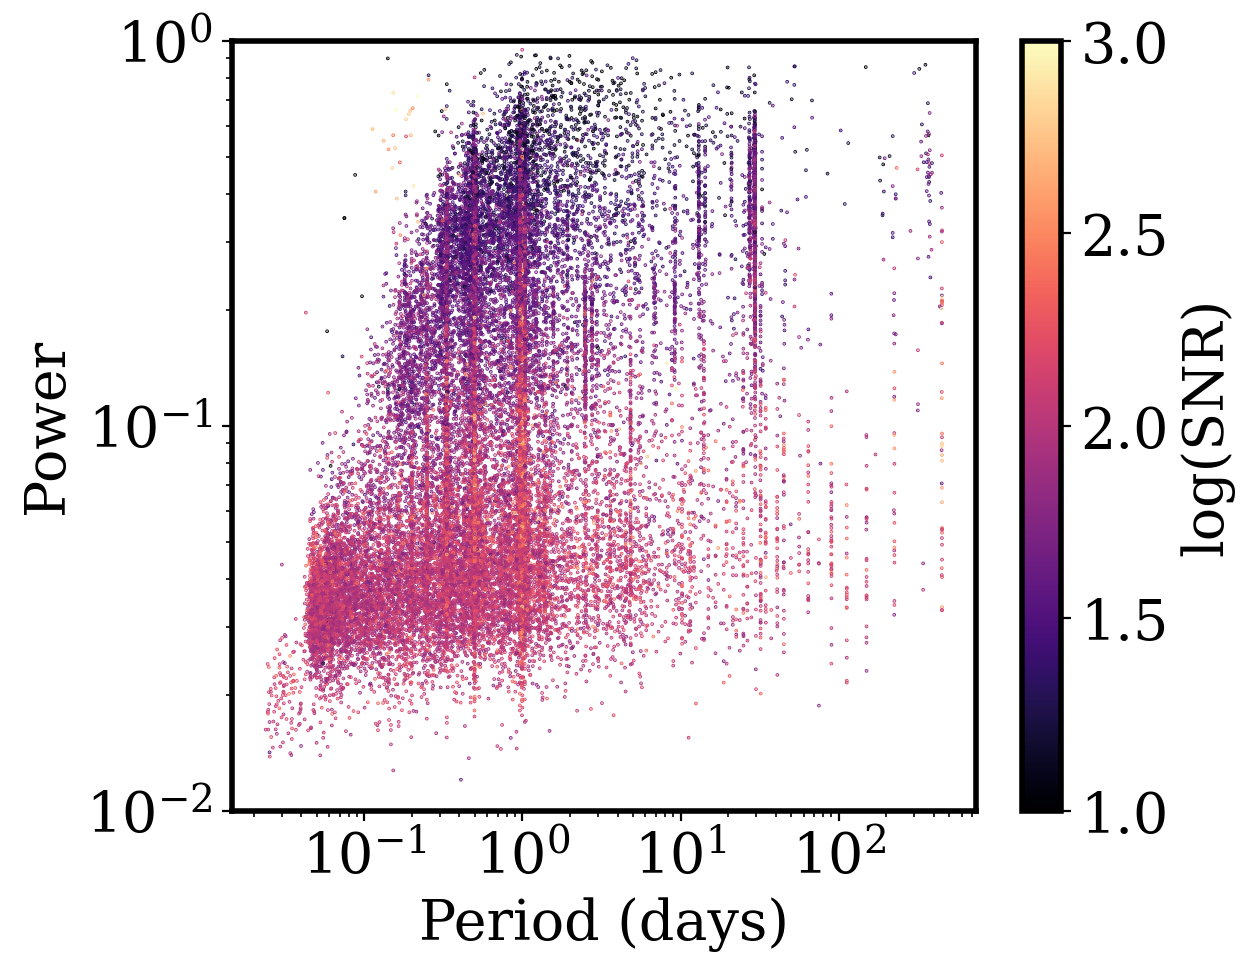

In [17]:
plt.figure(figsize=(6,5))
plt.scatter(features['period'], features['power'], s=0.1, c=np.log(features['snr']), cmap='magma', vmin=1, vmax=3)
plt.colorbar(label='log(SNR)')
plt.ylim(1e-2, 1e0)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.minorticks_on()

## Plot Lightcurve

We can now find a ZTF object with a high period SNR and that is bright, and plot the ZTF-r band light curve.

In [18]:
# Select good SNR candidate
features[(features['snr']>20) & (features['mean']<15)].head(5)

,period,power,snr,mean,invNeumann,NormExcessVar,Nphot
_hipscat_index,,,,,,,
1209433013427896320,0.217326,0.716238,22.941490,14.440848,32.595191,19957.636088,613.0
1209943734423126016,0.996238,0.352265,20.733923,14.714997,2.917700,276017.138205,660.0
1215978709064876032,0.787238,0.397713,24.706310,14.533778,2.560923,217372.218784,1137.0
1215995140963827712,0.499223,0.169421,22.202415,12.941055,1.087141,804302.105806,617.0
1216238507677188096,0.996239,0.098632,21.619643,14.316386,0.712379,941602.836716,1145.0


In [19]:
# Select a lightcurve with high SNR
object_id = 1209433013427896320 # hips index
best_period = 0.217326 # (in days) best period from the above table

In [27]:
# Get the light curve magnitudes
lc_object = _sources.loc[object_id].query("ztf_sources.band == 'r'")
lc = lc_object.ztf_sources.compute().iloc[0]
lc

,ra,dec,mjd,mag,magerr,band,catflags
0,133.662308,11.5501,59256.33602,14.475207,0.010433,r,0
1,133.662308,11.5501,58834.51785,14.587825,0.010447,r,0
2,133.662308,11.5501,58803.52650,14.376881,0.010429,r,0
3,133.662308,11.5501,58803.52695,14.364446,0.010429,r,0
4,133.662308,11.5501,58829.39228,14.410576,0.010429,r,-32768
...,...,...,...,...,...,...,...
665,133.662308,11.5501,58803.46485,14.533634,0.010439,r,0
666,133.662308,11.5501,58803.46395,14.531354,0.010438,r,0
667,133.662308,11.5501,58803.45673,14.526449,0.010438,r,0
668,133.662308,11.5501,58803.45989,14.545570,0.010440,r,0


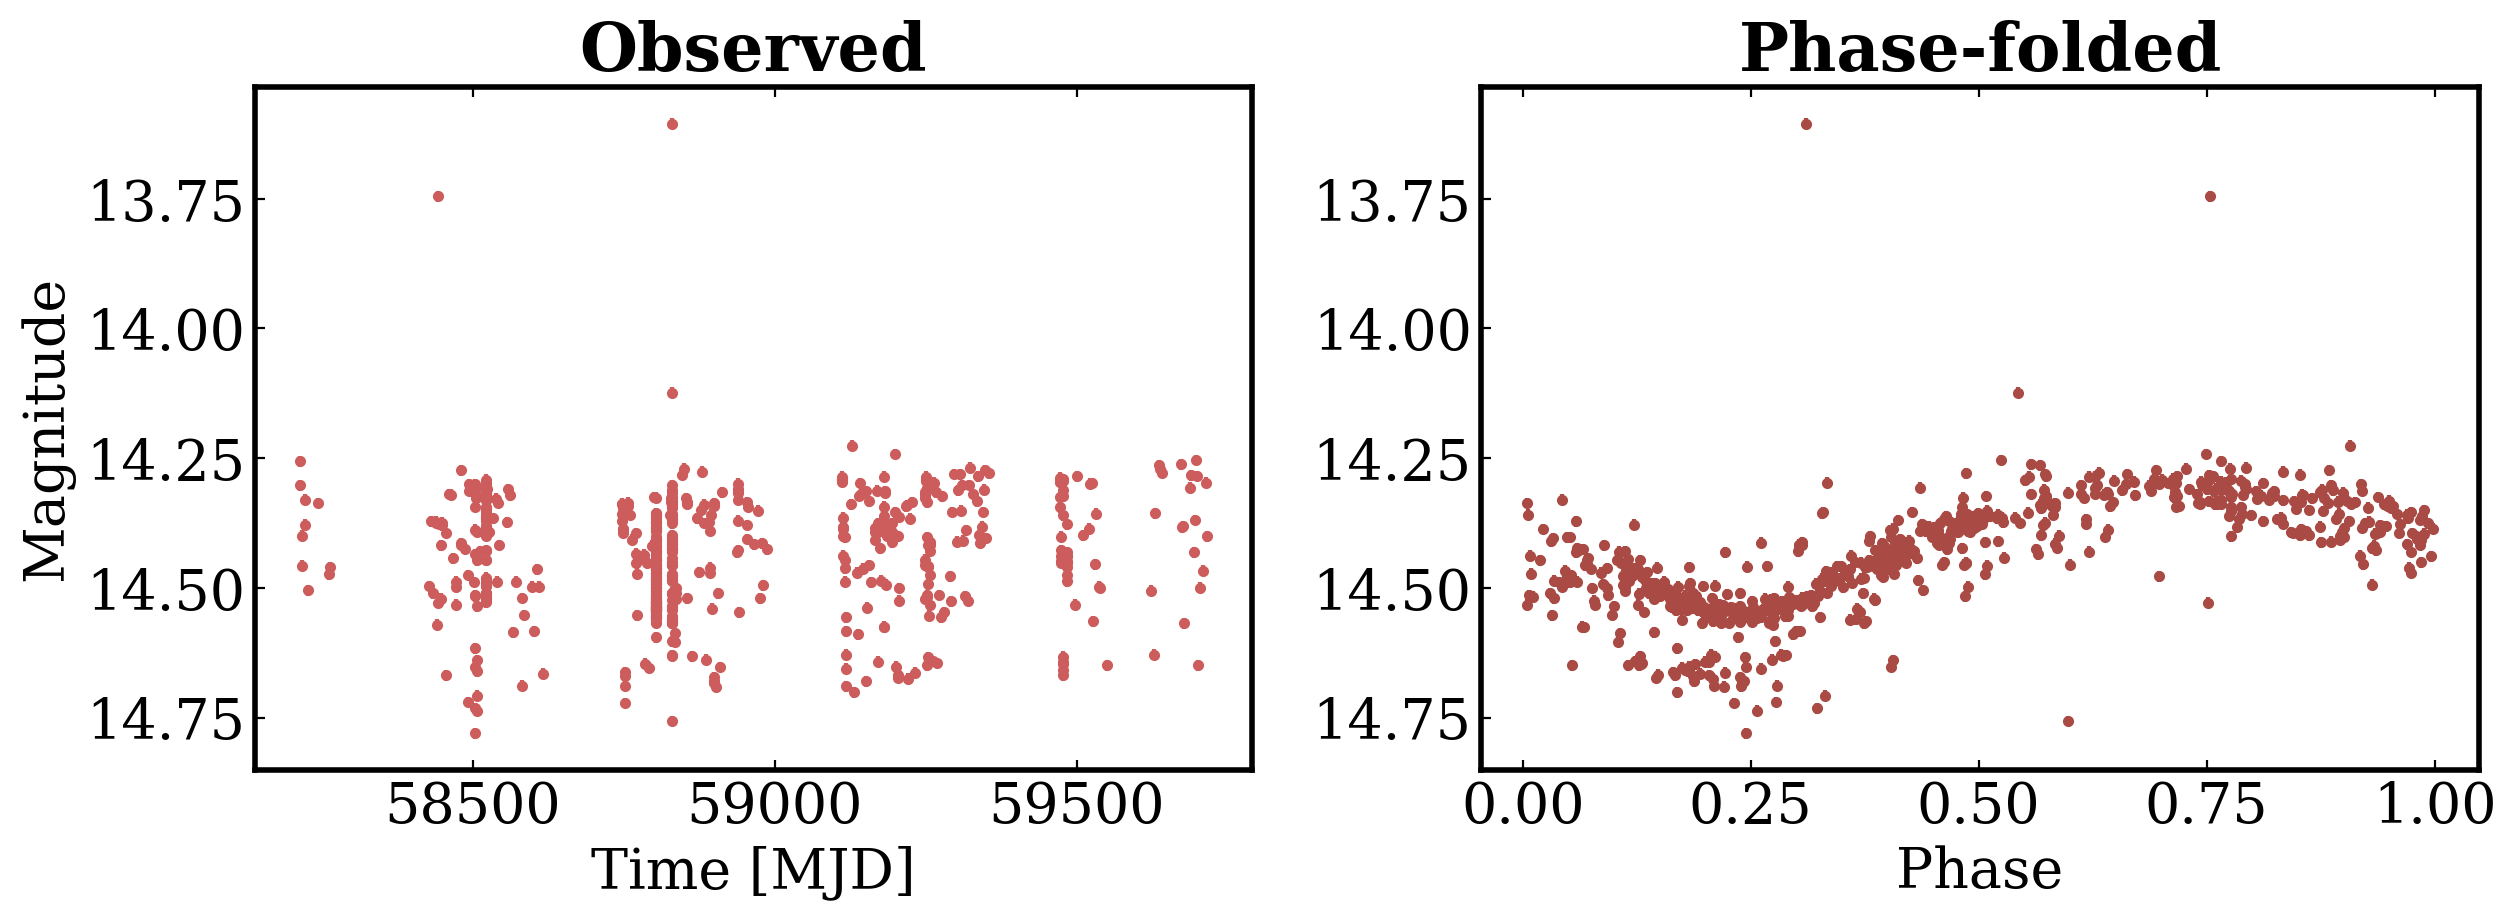

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].errorbar(
    lc["mjd"],
    lc["mag"],
    yerr=lc["magerr"], 
    fmt='.',
    color='indianred'
)

ax[1].errorbar((lc["mjd"].to_numpy()%best_period)/best_period, lc["mag"],
                yerr=lc["magerr"], fmt='.', color='#AA4A44')
ax[1].set_xlabel('Phase')
ax[0].set_xlabel('Time [MJD]')
ax[1].tick_params(axis='x', which='both', bottom=True, top=True, direction='in')
ax[0].tick_params(axis='x', which='both', bottom=True, top=True, direction='in')
ax[1].tick_params(axis='y', which='both', bottom=True, top=True, direction='in')
ax[0].tick_params(axis='y', which='both', bottom=True, top=True, direction='in')
ax[0].set_ylabel('Magnitude')
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_title("Observed", weight='bold')
ax[1].set_title("Phase-folded", weight='bold')

plt.tight_layout()

In [22]:
client.shutdown()